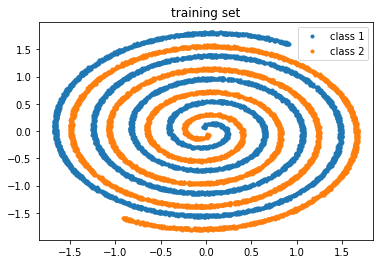

In [255]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.auto import tqdm
import seaborn as sns

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 2 * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(5000)
X = X/15

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [273]:
from skimage.io import imread

In [518]:
img = np.mean(imread('a.png'), axis=2)

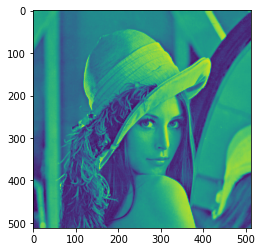

In [519]:
plt.imshow(img)

In [520]:
X = []
y = []
for x1 in tqdm(range(img.shape[0])):
    for x2 in range(img.shape[1]):
        X.append([x1, x2])
        y.append(img[x1, x2])

In [521]:
X = np.array(X)
y = np.array(y) / 255.
X = (X - np.min(X, axis=0))
X = 2 * (X / np.max(X, axis=0) - 0.5)

In [522]:
len(X)

262144

In [523]:
class LearnableActivation(nn.Module):
    def __init__(self, n_f=2, act_cls=nn.Tanh):
        super(LearnableActivation, self).__init__()
        self.max_deg = 3
        self.act = act_cls()
        self.create_w(n_f)
    
    def create_w(self, n_f):
        init = np.zeros((n_f, self.max_deg + 1), dtype=np.float32)
        init[:, 1] = 1.0
        self.n_f = n_f
        
        self.w = torch.nn.Parameter(torch.from_numpy(init), requires_grad=True)
    
    def forward(self, x):
        assert len(x.shape) == 2
#         self.create_w(x.shape[1])
        assert x.shape[1] == self.n_f
        
        self.w.data = torch.clamp(self.w.data, min=-1, max=1)
        
        results = []
        for deg in range(self.max_deg + 1):
            results.append((x ** deg) * self.w[:, deg])
            
        s = sum(results)
        s = self.act(s)
        return s

In [524]:
#LearnableActivation().cuda()(Xt)

In [525]:
class MyNet(nn.Module):
    def __init__(self, act_cls=None):
        super(MyNet, self).__init__()
        if act_cls is None:
            act_cls = nn.Tanh
        self.act = act_cls()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 1)
        self.act1 = nn.Tanh()
    def forward(self, x):
        x = self.act(x)
        x = self.act1(self.fc1(x))
        x = self.act1(self.fc2(x))
        x = self.act1(self.fc3(x))
        x = self.act1(self.fc4(x))
        x = self.act1(self.fc5(x))
        x = self.act1(self.fc6(x))
        x = self.fc7(x)
        return x
    
net = MyNet().cuda() #act_cls=LearnableActivation

In [526]:
Xt = torch.from_numpy(X).to(torch.float32).cuda()
yt = torch.from_numpy(y).to(torch.float32).cuda()

In [527]:
Xt

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9961],
        [-1.0000, -0.9922],
        ...,
        [ 1.0000,  0.9922],
        [ 1.0000,  0.9961],
        [ 1.0000,  1.0000]], device='cuda:0')

In [528]:
def loss():
    delta = (net(Xt).flatten() - yt) / 0.5
    return delta.pow(2).mean()

def acc():
    return ((net(Xt) > 0.5).flatten() == yt).to(torch.float32).mean().item()

In [529]:
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [530]:
losses = []
accs = []
i = 0

In [531]:
!rm plot*.png

rm: cannot remove 'plot*.png': No such file or directory


In [532]:
Xtorig = Xt
ytorig = yt

In [680]:
for i in tqdm(range(i, 2000000)):
    idxes = np.random.choice(len(Xtorig), 64)
    Xt = Xtorig[idxes]
    yt = ytorig[idxes]
    
    opt.zero_grad()
    l = loss()
    accs.append(acc())
    l.backward()
    opt.step()
    losses.append(l.item())
    
#     if i % 100 == 0:
#         fig = plot(with_data=False)
#         fig.savefig('plot_%05d.png' % i, bbox_inches='tight')
#         fig.clear()
#         plt.close(fig)
#         plt.clf()

KeyboardInterrupt: 

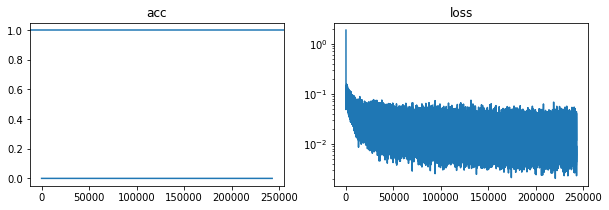

In [681]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(accs)
plt.axhline(1)
plt.subplot(1, 2, 2)
plt.title('loss')
plt.yscale('log')
plt.plot(losses)

In [682]:
#plt.imshow(net.act(xyt)[:, 1].flatten().detach().cpu().numpy().reshape(50, 50), cmap='gray')

In [683]:
def plot(with_data=True, S=500, M=1.3):
    x1 = np.linspace(-M, M, S)
    y1 = np.linspace(-M, M, S)
    xv, yv = np.meshgrid(x1, y1, sparse=False, indexing='ij')

    xynp = np.concatenate((xv.flatten()[:, np.newaxis], yv.flatten()[:, np.newaxis]), axis=1)

    xyt = torch.from_numpy(xynp).to(torch.float32).cuda()
    vals = net(xyt).detach().cpu().numpy().flatten().reshape(S, S)

    fig = plt.figure(figsize=(7, 7))
    plt.imshow(vals, extent=(-M, M, -M, M), cmap='gray', vmin=0, vmax=1)
    # sns.heatmap(vals,
    #             xticklabels=[round(z, 2) for z in x1],
    #             yticklabels=[round(z, 2) for z in y1])
    
#     if with_data:
#         plt.title('training set')
#         plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
#         plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
#         plt.legend()
    return fig

In [684]:
np.min(X), np.max(X)

(-1.0, 1.0)

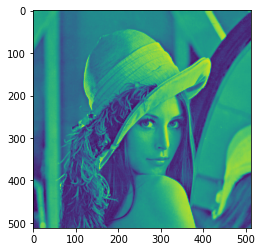

In [685]:
plt.imshow(img)

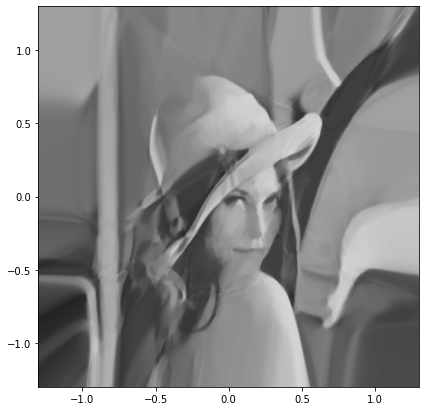

In [686]:
_ = plot()

<img src="plot_all.gif" /> 